# Deep Neural Network for Image Classification: Application¶

## 1 Importing the libraries and setting up enviornment

In [52]:
# importing the public libraries
import numpy as np
import matplotlib.pyplot as plt

import h5py
from google.colab import drive

import sys
import os

from sklearn.metrics import classification_report, accuracy_score

In [4]:
# defineing constants
PROJECT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Specialization/01 Neural Networks and Deep Learning/C1W4'

In [15]:
# setting up enviornments
drive.mount('/content/gdrive')
sys.path.append(PROJECT_DIR)

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# importing user-define libraries
import dnn_app_utils_v2

## 2. Prepare the dataset

In [10]:
train_set = h5py.File(os.path.join(PROJECT_DIR, 'datasets', 'train_catvnoncat.h5'), 'r')
test_set = h5py.File(os.path.join(PROJECT_DIR, 'datasets', 'test_catvnoncat.h5'), 'r')

In [13]:
train_set.keys(), test_set.keys()

(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [24]:
train_x_orig = np.array(train_set['train_set_x'])
test_x_orig = np.array(test_set['test_set_x'])
train_y_orig = np.array(train_set['train_set_y'])
test_y_orig = np.array(test_set['test_set_y'])
classes = np.array(train_set['list_classes'])
                   
train_x_orig.shape, test_x_orig.shape, train_y_orig.shape, test_y_orig.shape, classes

((209, 64, 64, 3),
 (50, 64, 64, 3),
 (209,),
 (50,),
 array([b'non-cat', b'cat'], dtype='|S7'))

This is a non-cat image.


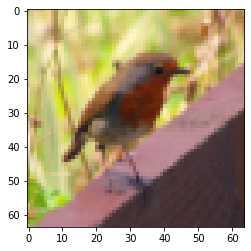

In [25]:
# display a sample image
index = 10
plt.imshow(train_x_orig[index])
print('This is a %s image.'%(classes[train_y_orig[index]]).decode('utf-8'))

### 2.1 data preprocessing
1. reshape our dataset to the following dimensions:
- X : (n_x, m)
- Y : (1, m)
2. standardize X

In [33]:
train_x = train_x_orig.reshape((train_x_orig.shape[0], -1)).T
test_x = test_x_orig.reshape((test_x_orig.shape[0], -1)).T

train_y = train_y_orig.reshape((1, -1))
test_y = test_y_orig.reshape((1, -1))

train_x = train_x / 255.
test_x = test_x / 255.

train_x.shape, test_x.shape, train_y.shape, test_y.shape, classes

((12288, 209),
 (12288, 50),
 (1, 209),
 (1, 50),
 array([b'non-cat', b'cat'], dtype='|S7'))

In [34]:
m_train = train_x.shape[1]
num_px = train_x_orig.shape[1]
m_test = test_x.shape[1]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))


Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


## 3. Architecture of your model



In [46]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
  """
  Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.

  Arguments:
  X -- input data, of shape (n_x, number of examples)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
  layers_dims -- dimensions of the layers (n_x, n_h, n_y)
  num_iterations -- number of iterations of the optimization loop
  learning_rate -- learning rate of the gradient descent update rule
  print_cost -- If set to True, this will print the cost every 100 iterations 

  Returns:
  parameters -- a dictionary containing W1, W2, b1, and b2
  """

  n_x, n_h, n_y = layers_dims

  parameters = dnn_app_utils_v2.initialize_parameters(n_x, n_h, n_y)
  costs = []
  grads = {}

  A_prev = X
  for i in range(num_iterations):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    # forward prop
    A1, cache1 = dnn_app_utils_v2.linear_activation_forward(X,  W1, b1, 'relu')
    AL, cache2 = dnn_app_utils_v2.linear_activation_forward(A1,  W2, b2, 'sigmoid')
    # compute cost
    cost = dnn_app_utils_v2.compute_cost(AL, Y)
    # backward prop
    dA2 = - np.divide(Y, AL) + np.divide(1-Y, 1-AL)
    dA1, dW2, db2 = dnn_app_utils_v2.linear_activation_backward(dA2, cache2, 'sigmoid')
    dA0, dW1, db1 = dnn_app_utils_v2.linear_activation_backward(dA1, cache1, 'relu')
    
    grads['dW2'] = dW2   
    grads['db2'] = db2
    grads['dW1'] = dW1
    grads['db1'] = db1

    # update parameters
    parameters = dnn_app_utils_v2.update_parameters(parameters, grads, learning_rate)

    if print_cost and i % 100 == 0:
      costs.append(cost)
      print('cost at iter %d : %f'%(i, cost))

  plt.plot(costs)
  plt.xlabel('iteration (per hundred)')
  plt.ylabel('costs')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return parameters

cost at iter 0 : 0.693050
cost at iter 100 : 0.646432
cost at iter 200 : 0.632514
cost at iter 300 : 0.601502
cost at iter 400 : 0.560197
cost at iter 500 : 0.515830
cost at iter 600 : 0.475490
cost at iter 700 : 0.433916
cost at iter 800 : 0.400798
cost at iter 900 : 0.358071
cost at iter 1000 : 0.339428
cost at iter 1100 : 0.305275
cost at iter 1200 : 0.274914
cost at iter 1300 : 0.246818
cost at iter 1400 : 0.198507
cost at iter 1500 : 0.174483
cost at iter 1600 : 0.170808
cost at iter 1700 : 0.113065
cost at iter 1800 : 0.096294
cost at iter 1900 : 0.083426
cost at iter 2000 : 0.074391
cost at iter 2100 : 0.066307
cost at iter 2200 : 0.059193
cost at iter 2300 : 0.053361
cost at iter 2400 : 0.048555


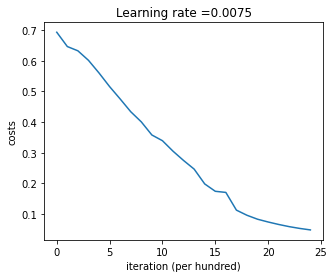

In [47]:
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)



In [58]:
def predict(X, Y, parameters):
  AL, cache = dnn_app_utils_v2.L_model_forward(X, parameters)
  AL[AL > 0.5] = 1
  AL[AL <= 0.5] = 0
  Y_sklearn = Y.reshape((-1, 1))
  AL_sklearn = AL.reshape((-1, 1))
  print( accuracy_score(Y_sklearn, AL_sklearn))

In [59]:
predict(train_x, train_y, parameters)

1.0


In [60]:
predict(test_x, test_y, parameters)

0.72


In [67]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
  """
  Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

  Arguments:
  X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
  layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
  learning_rate -- learning rate of the gradient descent update rule
  num_iterations -- number of iterations of the optimization loop
  print_cost -- if True, it prints the cost every 100 steps

  Returns:
  parameters -- parameters learnt by the model. They can then be used to predict.
  """
  np.random.seed(1)
  L = len(layers_dims) - 1
  costs = []
  parameters = dnn_app_utils_v2.initialize_parameters_deep(layers_dims)
  for i in range(num_iterations):
    AL, caches = dnn_app_utils_v2.L_model_forward(X, parameters)
    cost = dnn_app_utils_v2.compute_cost(AL, Y)
    grads = dnn_app_utils_v2.L_model_backward(AL, Y, caches)
    parameters = dnn_app_utils_v2.update_parameters(parameters, grads, learning_rate)

    if print_cost and i % 100 == 0:
      costs.append(cost)
      print('cost at iter %d : %f'%(i, cost))

  plt.plot(costs)
  plt.xlabel('iteration (per hundred)')
  plt.ylabel('costs')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return parameters



cost at iter 0 : 0.771749
cost at iter 100 : 0.672053
cost at iter 200 : 0.648263
cost at iter 300 : 0.611507
cost at iter 400 : 0.567047
cost at iter 500 : 0.540138
cost at iter 600 : 0.527930
cost at iter 700 : 0.465477
cost at iter 800 : 0.369126
cost at iter 900 : 0.391747
cost at iter 1000 : 0.315187
cost at iter 1100 : 0.272700
cost at iter 1200 : 0.237419
cost at iter 1300 : 0.199601
cost at iter 1400 : 0.189263
cost at iter 1500 : 0.161189
cost at iter 1600 : 0.148214
cost at iter 1700 : 0.137775
cost at iter 1800 : 0.129740
cost at iter 1900 : 0.121225
cost at iter 2000 : 0.113821
cost at iter 2100 : 0.107839
cost at iter 2200 : 0.102855
cost at iter 2300 : 0.100897
cost at iter 2400 : 0.092878


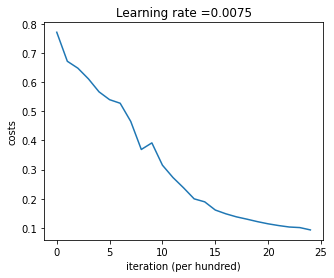

In [68]:
layers_dims = [12288, 20, 7, 5, 1] 

parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)


In [69]:
predict(train_x, train_y, parameters)

0.9856459330143541


In [70]:
predict(test_x, test_y, parameters)

0.8
